<a href="https://colab.research.google.com/github/blueeagle100/3d_bounding_boxes/blob/main/3d_box_lidar_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Bounding Boxes from LiDAR Point Cloud Data**

In this tutorial we will learn how to draw 3D bounding boxes on objects detected by the LiDAR and the camera.

The high level pipeline will be:
- Get Object detections on image.
- Obtain LiDAR point cloud and remove ground plane via RANSAC
- Cluster objects in LiDAR space
- Associate detected objects with clustered objects in image space
- Get 3D location of clustered objects in image/camera space
- Draw 3D bounding boxes on the image

Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-09-03 12:22:19--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.219
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  27.9MB/s    in 34s     

2022-09-03 12:22:53 (26.4 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-09-03 12:22:53--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.29
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-09-03 12:22:54 (178 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [3]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [4]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [5]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [6]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [7]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [8]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [9]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

#### **Get LiDAR to Camera Rotation and Translation Matrices**

In [10]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

The LiDAR to Camer translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space

$$ y = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$
NOTE:  x is the 3D point in homogeneous coordinates.

Since we will be using the left image we will go ahead and make a function to rotate a single LiDAR poin to the left image.

In [247]:
# matrix to transform from velo (LiDAR) to left color camera
T_mat = P_left @ R_left_rect @ T_cam_velo
T_mat

array([[     613.04,     -718.58,       -2.95,     -124.07],
       [     182.76,       12.24,     -718.99,     -101.61],
       [    0.99989,   0.0046974,    0.013829,    -0.26912]])

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [12]:
def velo2camera(velo_points, image=None, remove_outliers=True):
    ''' maps velo points (LiDAR) to camera (u,v,z) space '''
    # convert to (left) camera coordinates
    # P_left @ R_left_rect @ T_cam_velo
    velo_camera =  T_mat @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = velo_camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

In [13]:
from sklearn import linear_model

def bin2h_velo(lidar_bin, remove_plane=True):
    ''' Reads LiDAR bin file and returns homogeneous (x,y,z,1) LiDAR points'''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    velo_points = scan_data[:, 0:3] 

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
            ransac = linear_model.RANSACRegressor(
                                          linear_model.LinearRegression(),
                                          residual_threshold=0.1,
                                          max_trials=5000
                                          )

            X = velo_points[:, :2]
            y = velo_points[:, -1]
            ransac.fit(X, y)


            # remove outlier points
            mask = ransac.inlier_mask_
            velo_points = velo_points[~mask]

    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T 

    return velo_points

In [14]:
def project_velo2cam(lidar_bin, image, remove_plane=True):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get homogeneous LiDAR points from binn file
    velo_points = bin2h_velo(lidar_bin, remove_plane)

    # get camera (u, v, z) coordinates
    velo_camera = velo2camera(velo_points, image, remove_outliers=True)
    
    return velo_camera

In [15]:
index = 120

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

(u, v, z) = project_velo2cam(lidar_bin, left_image)

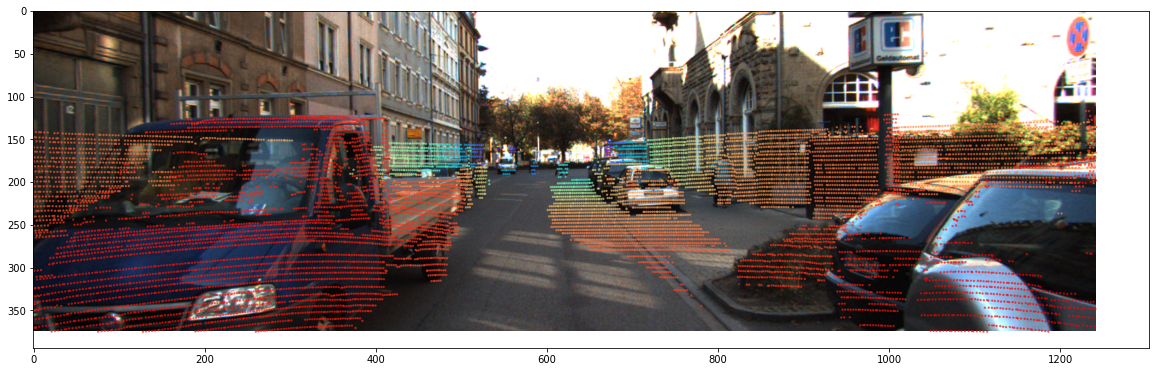

In [16]:
# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

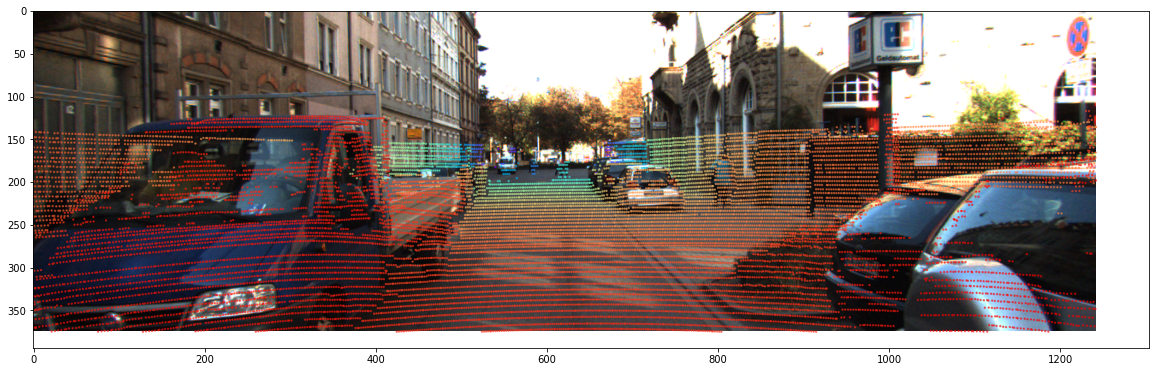

In [17]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=False)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Get Object Detection Pipeline**

Any object detector will work, we will use yolov5 to get the job done.

In [18]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12169, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 12169 (delta 11), reused 12 (delta 3), pack-reused 12140
Receiving objects: 100% (12169/12169), 12.61 MiB | 27.24 MiB/s, done.
Resolving deltas: 100% (8368/8368), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [20]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-3 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [21]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [22]:
def get_distances(image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int), 
                             np.round(x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return image, bboxes_out

In [23]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True, 
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    left_image, bboxes_out = get_distances(left_image, 
                                           velo_camera, 
                                           bboxes, 
                                           draw=draw_depth)

    return left_image, bboxes_out, velo_camera

## **Test the base pipeline**

In [24]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

left_image, bboxes_out, velo_camera = get_depth_detections(left_image, 
                                                           lidar_bin, 
                                                           draw_boxes=True, 
                                                           draw_depth=True)

In [25]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):
   
    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1, 
                  color_map(z[i]), -1);

    return velo_image


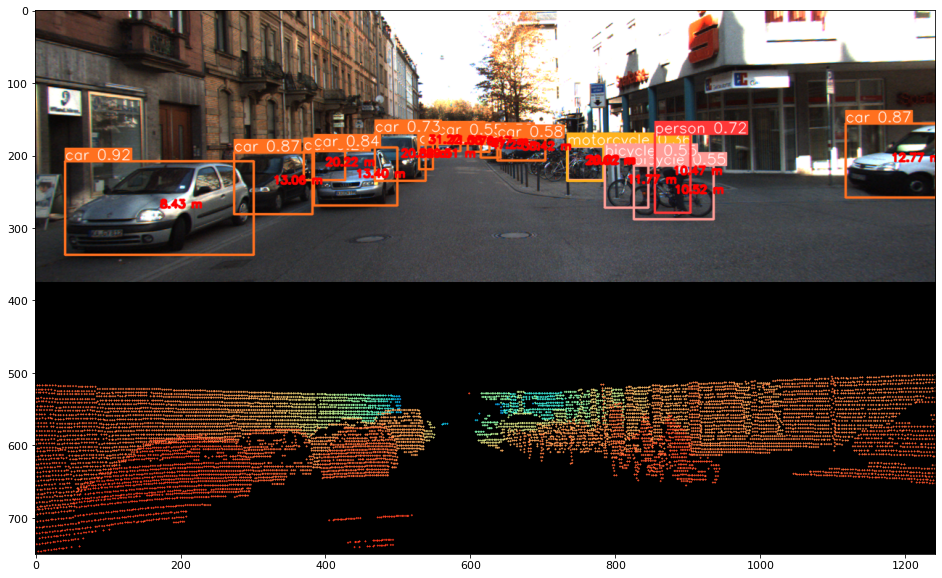

In [26]:
velo_image = np.zeros_like(left_image)
velo_image = draw_velo_on_image(velo_camera, velo_image)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

## **Lets move on to extracting 3D point cloud objects**

We will use DBSCAN to cluster the points in LiDAR space. We will then project each of the 3D LiDAR clusters into u,v image space. Then will we will reduce the amount of clusters via size and proximity to the detected objects. Then we will draw bounding boxes around the clusters in image space.

In [184]:
def image_clusters_from_velo(velo_points, labels, image):
    ''' Obtains clusters in image space from velo (LiDAR) points 
        Inputs:
            velo_points (4xN) Homogeneous LiDAR points
            labels (N,) cluster labels (clusters formed in LiDAR space)
            image - reference image for transformation from LiDAR to image space
        Outputs:
            cam_clusters (dict) contains each camera cluster label and cluster
        '''
    cam_clusters = {}
    for label in np.unique(labels):

        # convert from velo to camera 
        velo_cam = velo2camera(velo_points[:, labels == label], image)
        
        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            cam_clusters.update({label : velo_cam})

    return cam_clusters

In [185]:
def draw_clusters_on_image(image, cluster_dict, draw_centroids=False):
    ''' draws the clusters on an image '''
    pastel = cm.get_cmap('Pastel2', lut=50)
    get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

    for label, cluster in cluster_dict.items():
        for (u, v, z) in cluster.T:
            cv2.circle(image, (int(u), int(v)), 1, 
                       get_pastel(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster, axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5, 
                       get_pastel(label), -1);

    return image


## Read LiDAR data directly from bin file

Here we will cluster the objects in LiDAR space

In [186]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

##  Use DBSCAN to cluster points

We could also use K-Means clustering seeded with the object detection centers, but this didn't seem to work as well

In [187]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(min_samples=30)

In [189]:
labels = dbscan.labels_
cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

In [190]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, cam_clusters, draw_centroids=True)

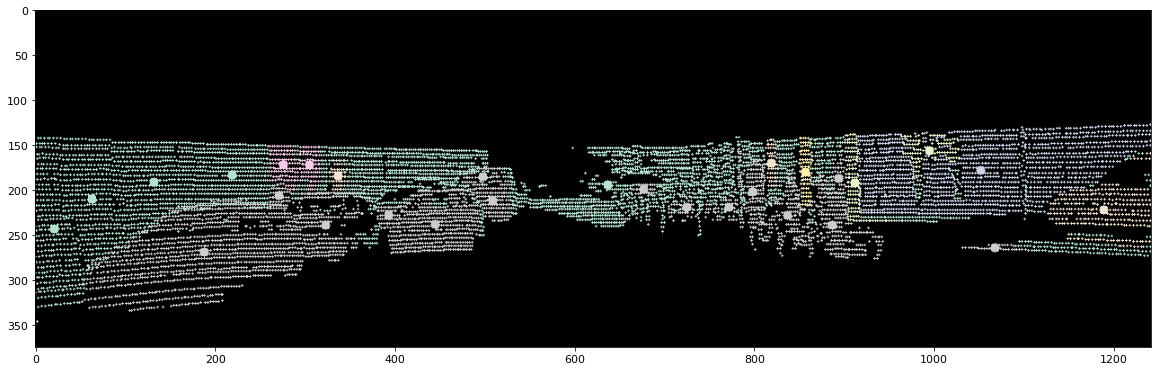

In [191]:
plt.imshow(new_image);

## **Now create pipeline to place 3D bounding boxes on object**

DBSCAN seems to work well, you could also try K-means or even Gaussian Mixture modeling with the detections seeded as the innitial centroids, but that approach did not provide good results. 

Now we need to associate the LiDAR clusters with the detected objects. The initial approach that I took was to use the Hungarian Algorithm to do the matching, but I couldn't get any decent results. So instead I chose to fuse the data in the camera space by determining if the cluster centroid was close enough to the detected object (u,v,z) center. This is an inutitive approach and works well enough. However it does not make a good use of the detected objects, we could almost perform this whole pipeline unsupervised and not have to do any detections

In [165]:
from sklearn.cluster import DBSCAN

def get_clusters(velo_points):
    dbscan = DBSCAN(eps=0.5, min_samples=30)
    dbscan.fit(velo_points[:3, :].T)

    labels = dbscan.labels_

    return dbscan, labels

In [233]:
def get_likely_clusters(cluster_dict, object_centers, min_thresh=50, thresh=75):
    ''' Obtains more likely clusters '''

    new_clusters = {}
    noise_cluster = cluster_dict[-1]

    labels = sorted(cluster_dict)

    for label in labels:
        cluster = cluster_dict[label]

        if cluster.shape[1] > min_thresh \
           and cluster.shape[1] < noise_cluster.shape[1] //2: 

            # ensure centroid has correct order
            centroid = np.mean(cluster, axis=1)[[1, 0, 2]]

            # check if any objects are detected
            if len(object_centers) > 0:
                delta = np.linalg.norm(centroid - object_centers, axis=1)
                min_loc = np.argmin(delta)

                if delta[min_loc] < thresh:
                    new_clusters.update({label : cluster})

            else:
                new_clusters.update({label : cluster})

    return new_clusters

In [234]:
def get_3d_bboxes(cluster_dict, labels, velo_points):
    camera_box_point_list = []

    for c_label, cluster in cluster_dict.items():

        velo_cluster = velo_points[:3, labels == c_label]

        (x_min, y_min, z_min) = velo_cluster.min(axis=1)
        (x_max, y_max, z_max) = velo_cluster.max(axis=1)

        # now get points to define 3d bounding box
        # box_points = np.array([[x_max, y_max, z_max]]) * arr
        # just manually do this for now
        box_points = np.array([
            [x_max, y_max, z_max, 1],
            [x_max, y_max, z_min, 1],
            [x_max, y_min, z_max, 1],
            [x_max, y_min, z_min, 1],
            [x_min, y_max, z_max, 1],
            [x_min, y_max, z_min, 1],
            [x_min, y_min, z_max, 1],
            [x_min, y_min, z_min, 1]
        ])

        # convert these box points to image space
        camera_box_points = T_mat @ box_points.T
        camera_box_points[:2] /= camera_box_points[2, :]

        camera_box_points = camera_box_points.round().T.astype(int)

        # append to list
        camera_box_point_list.append(camera_box_points)

    return camera_box_point_list

In [235]:
pastel = cm.get_cmap('Pastel2', lut=50)
get_pastel = lambda z : [255*val for val in pastel(z)[:3]]

def draw_3d_boxes(image, camera_box_points):
    for i, box_pts in enumerate(camera_box_points):
        [A, B, C, D, E, F, G, H] = box_pts[:, :2]
        color = get_pastel(i)

        # draw rear box (X-axis is forward for LiDAR)
        cv2.line(image, A, B, color, 2)
        cv2.line(image, B, D, color, 2)
        cv2.line(image, A, C, color, 2)
        cv2.line(image, D, C, color, 2)
        
        # draw front box
        cv2.line(image, G, E, color, 2)
        cv2.line(image, H, F, color, 2)
        cv2.line(image, G, H, color, 2)
        cv2.line(image, E, F, color, 2)

        # draw sides
        cv2.line(image, E, A, color, 2)
        cv2.line(image, G, C, color, 2)
        cv2.line(image, F, B, color, 2)
        cv2.line(image, H, D, color, 2)

    return image

## **Test the pipeline on an image**

In [236]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too


In [244]:
def main_pipeline(left_image, lidar_bin, velo_points):
    # get object detections
    left_image, bboxes_out, velo_camera = get_depth_detections(left_image, 
                                                           lidar_bin, 
                                                           draw_boxes=False, 
                                                           draw_depth=False)
    
    # perform clustering in LiDAR space
    dbscan, labels = get_clusters(velo_points)


    # get clusters in image space
    cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

    # get object centers in camera (u, v, z) coordinates
    object_centers = bboxes_out[:, 6:]

    # remove small and large clusters also remove cluster far away from detected objects
    cam_clusters = get_likely_clusters(cam_clusters, object_centers, min_thresh=50, thresh=75)

    # get 3D bbox points in camera space from clusters
    camera_box_points = get_3d_bboxes(cam_clusters, labels, velo_points)

    # draw 3D bounding boxes on the image
    left_image = draw_3d_boxes(left_image, camera_box_points)

    return left_image, cam_clusters



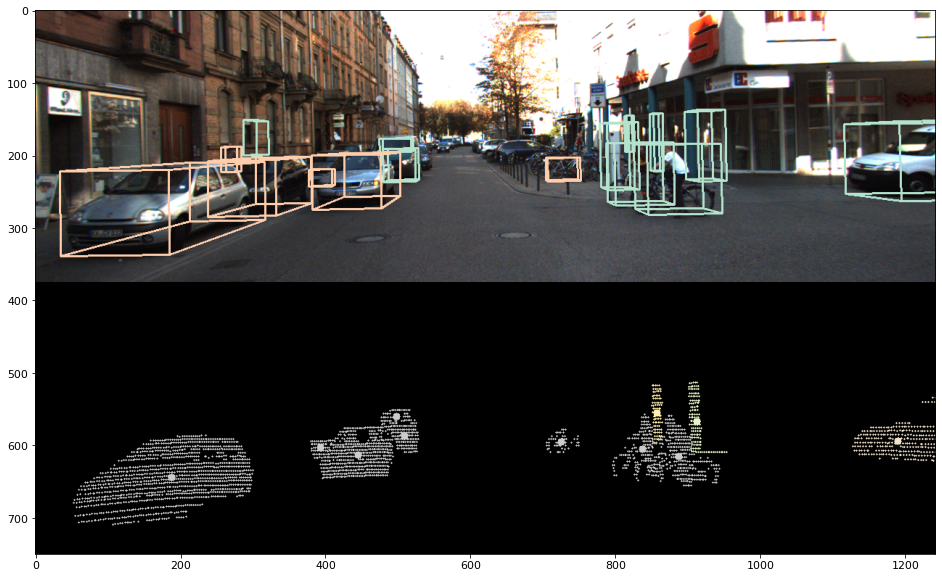

In [245]:
# run pipeline
left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

# draw projected clusters on new image
cluster_image = np.zeros_like(left_image)
cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

stacked = np.vstack((left_image, cluster_image))

plt.imshow(stacked)

## **Now let's use this pipeline to create a video**

In [246]:
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    # read in raw velo points 
    velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too

    # run pipeline
    left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

    # draw projected clusters on new image
    cluster_image = np.zeros_like(left_image)
    cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

    # stack frames
    stacked = np.vstack((left_image, cluster_image))

    # add to result video
    result_video.append(stacked)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('3dboxed_pointcloud_stack_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

## **Now let's run the depth check on another sample of KITTI data!**

In [248]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-09-03 13:24:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.165
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  27.5MB/s    in 1m 48s  

2022-09-03 13:26:27 (27.4 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [249]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-09-03 13:26:28--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.113
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-09-03 13:26:28 (23.5 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [250]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [251]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [252]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [253]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

# matrix to transform from velo (LiDAR) to left color camera
T_mat = P_left @ R_left_rect @ T_cam_velo
T_mat

array([[      610.5,     -715.96,     -11.211,     -141.56],
       [     183.06,      10.283,     -719.33,     -93.869],
       [    0.99998,   0.0046558,  -0.0029325,    -0.28813]])

In [254]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [255]:
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    # read in raw velo points 
    velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too

    # run pipeline
    left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

    # draw projected clusters on new image
    cluster_image = np.zeros_like(left_image)
    cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

    # stack frames
    stacked = np.vstack((left_image, cluster_image))

    # add to result video
    result_video.append(stacked)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('3dboxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('3dboxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

In [256]:
stacked.shape

(752, 1241, 3)

In [257]:
752//2

376

In [258]:
1241//2

620